### Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, metrics, layers
from sklearn.model_selection import train_test_split
import random
import numpy as np
import os 
import cv2
import warnings
import matplotlib.pyplot as plt
#Intialize Random Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
warnings.filterwarnings("ignore")
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Print GPU details
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        print("Device:", gpu)
else:
    print("No GPU found. Make sure GPU is enabled in Kaggle settings.")
# Set TensorFlow to run on GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled for TensorFlow!")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 1
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU enabled for TensorFlow!


### Import Data and Remove Duplicates

In [2]:
dataset_path = "/kaggle/input/shop-dataset/Shop DataSet" 

non_shop_lifters_path = os.path.join(dataset_path, "non shop lifters")
shop_lifters_path = os.path.join(dataset_path, "shop lifters")

def get_unique_videos(folder_path, underscore_count):
    """Retrieve video files, filtering out duplicates based on underscore count."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
    
    print(f"\nTotal videos in '{folder_path}' before filtering: {len(video_files)}")

    # Filter out videos where the filename contains the specified number of underscores
    unique_videos = [os.path.join(folder_path, f) for f in video_files if f.count('_') != underscore_count]

    print(f"Total videos in '{folder_path}' after filtering: {len(unique_videos)}")

    return unique_videos

# Get unique video files from both categories with respective underscore rules
non_shop_lifters_videos = get_unique_videos(non_shop_lifters_path, 4)  
shop_lifters_videos = get_unique_videos(shop_lifters_path, 3)  




Total videos in '/kaggle/input/shop-dataset/Shop DataSet/non shop lifters' before filtering: 531
Total videos in '/kaggle/input/shop-dataset/Shop DataSet/non shop lifters' after filtering: 313

Total videos in '/kaggle/input/shop-dataset/Shop DataSet/shop lifters' before filtering: 324
Total videos in '/kaggle/input/shop-dataset/Shop DataSet/shop lifters' after filtering: 324


### Length of Videos Visualization

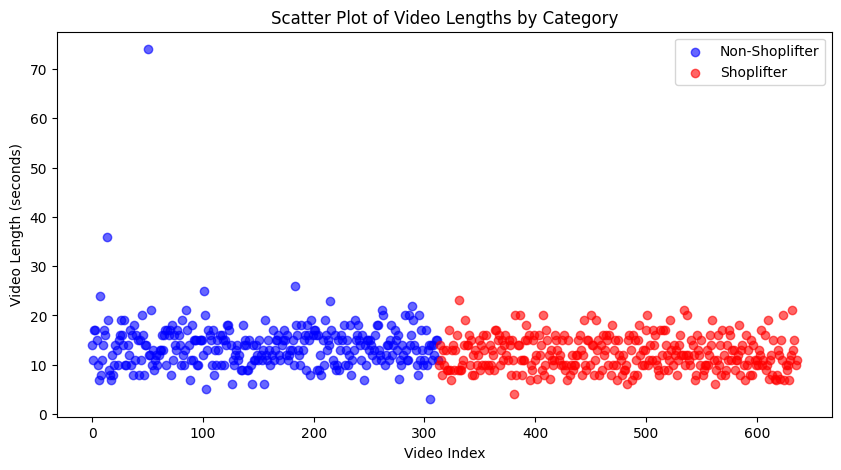

In [3]:
# Function to get video length
def get_video_length(video_path):
    """Get the duration (length) of a video in seconds."""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total frames
    cap.release()
    
    if fps > 0:
        return frame_count / fps  # Duration in seconds
    else:
        return None  # Handle potential errors

# Extract video lengths for both categories
non_shop_lengths = [get_video_length(video) for video in non_shop_lifters_videos if get_video_length(video) is not None]
shop_lengths = [get_video_length(video) for video in shop_lifters_videos if get_video_length(video) is not None]

# Create video indices
non_shop_indices = list(range(len(non_shop_lengths)))
shop_indices = list(range(len(non_shop_lengths), len(non_shop_lengths) + len(shop_lengths)))

# Create scatter plot
plt.figure(figsize=(10, 5))

plt.scatter(non_shop_indices, non_shop_lengths, color="blue", label="Non-Shoplifter", alpha=0.6)
plt.scatter(shop_indices, shop_lengths, color="red", label="Shoplifter", alpha=0.6)

# Labels and title
plt.xlabel("Video Index")
plt.ylabel("Video Length (seconds)")
plt.title("Scatter Plot of Video Lengths by Category")
plt.legend() 
plt.show()

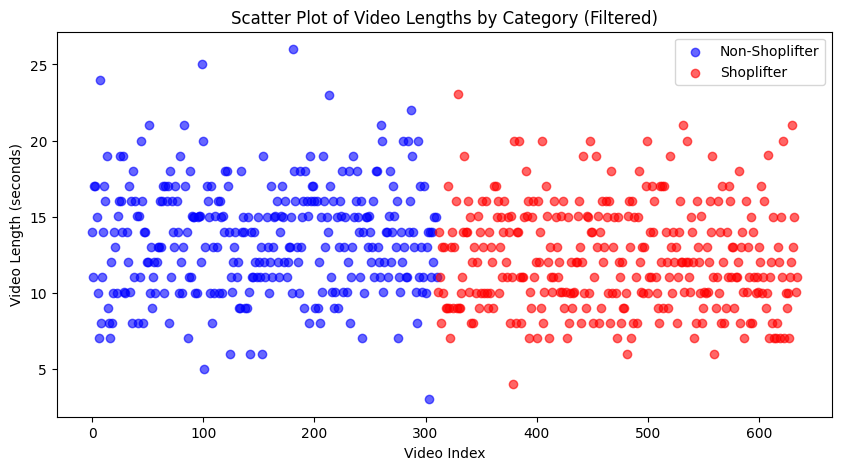

In [4]:
# Define a threshold for video length
MAX_VIDEO_LENGTH = 35  

# Filter non-shoplifter videos
filtered_non_shop_lengths = [length for length in non_shop_lengths if length <= MAX_VIDEO_LENGTH]

# Filter shoplifter videos
filtered_shop_lengths = [length for length in shop_lengths if length <= MAX_VIDEO_LENGTH]

# Create new video indices after filtering
filtered_non_shop_indices = list(range(len(filtered_non_shop_lengths)))
filtered_shop_indices = list(range(len(filtered_non_shop_lengths), len(filtered_non_shop_lengths) + len(filtered_shop_lengths)))

# Create scatter plot
plt.figure(figsize=(10, 5))

plt.scatter(filtered_non_shop_indices, filtered_non_shop_lengths, color="blue", label="Non-Shoplifter", alpha=0.6)
plt.scatter(filtered_shop_indices, filtered_shop_lengths, color="red", label="Shoplifter", alpha=0.6)

# Labels and title
plt.xlabel("Video Index")
plt.ylabel("Video Length (seconds)")
plt.title("Scatter Plot of Video Lengths by Category (Filtered)")
plt.legend()
plt.show()


### Data Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Constants
IMG_SIZE = (128, 128)   # Resize frames
NUM_FRAMES = 16         # Fixed number of frames per video
BATCH_SIZE = 4         # Adjust based on GPU memory
BUFFER_SIZE = 100       # For shuffling
CHANNELS = 3            # RGB

dataset_path = "/kaggle/input/shop-dataset/Shop DataSet"

# Define paths for categories
categories = {
    "non shop lifters": 0,  # Label 0
    "shop lifters": 1       # Label 1
}

def get_unique_videos(folder_path, underscore_count):
    """Retrieve video files, filtering out duplicates based on underscore count."""
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')]
    unique_videos = [os.path.join(folder_path, f) for f in video_files if f.count('_') != underscore_count]
    return unique_videos

# Collect video paths and labels
video_paths = []
labels = []

for category, label in categories.items():
    folder_path = os.path.join(dataset_path, category)
    unique_videos = get_unique_videos(folder_path, underscore_count=4 if label == 0 else 3)  
    video_paths.extend(unique_videos)
    labels.extend([label] * len(unique_videos))  # Assign label to each video


# Handle stratification issues
label_counts = Counter(labels)
min_class_count = min(label_counts.values())

stratify = labels if min_class_count >= 2 else None
# First, split into train (70%) and val (30%) 
train_paths, val_paths, train_labels, val_labels = train_test_split(
    video_paths, labels, test_size=0.3,random_state=SEED, stratify=stratify
)

# # First, split into train (70%) and temp (30%) [temp will be further split into val & test]
# train_paths, temp_paths, train_labels, temp_labels = train_test_split(
#     video_paths, labels, test_size=0.3,random_state=SEED, stratify=stratify
# )

# # Now, split temp (30%) into validation (15%) and test (15%)
# val_paths, test_paths, val_labels, test_labels = train_test_split(
#     temp_paths, temp_labels, test_size=0.5,random_state=SEED,stratify=temp_labels if stratify is not None else None
# )

# Define dataset length
num_train_samples = len(train_paths)
num_val_samples = len(val_paths)
# num_test_samples = len(test_paths)

# Define steps per epoch
steps_per_epoch = max(1, num_train_samples // BATCH_SIZE)
validation_steps = max(1, num_val_samples // BATCH_SIZE)
# test_steps = max(1, num_test_samples // BATCH_SIZE)


def load_video(video_path, num_frames=NUM_FRAMES):
    """Load a video, extract fixed frames, and preprocess."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames > num_frames:
        frame_interval = total_frames // num_frames  # Sample evenly across the video
    else:
        frame_interval = 1  # Take all frames if the video is too short

    for i in range(num_frames):
        frame_idx = min(i * frame_interval, total_frames - 1)  # Avoid out-of-bounds
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
        frames.append(frame)

    cap.release()

    # Pad if not enough frames
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((*IMG_SIZE, CHANNELS)))  # Use last frame or black

    return np.array(frames, dtype=np.float32)  # Shape: (NUM_FRAMES, 128, 128, 3)


def video_generator(paths, labels):
    """Generator function to load and yield video tensors with labels."""
    for path, label in zip(paths, labels):
        video = load_video(path)
        yield video, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: video_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(NUM_FRAMES, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: video_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(NUM_FRAMES, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# test_dataset = tf.data.Dataset.from_generator(
#     lambda: video_generator(test_paths, test_labels),
#     output_signature=(
#         tf.TensorSpec(shape=(NUM_FRAMES, 128, 128, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(), dtype=tf.int32)
#     )
# )

# Apply batching, shuffling, and prefetching
train_dataset = (train_dataset
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE).repeat())

val_dataset = (val_dataset
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE).repeat())
# test_dataset = (test_dataset
#                .batch(BATCH_SIZE)
#                .prefetch(tf.data.AUTOTUNE).repeat())

# Print dataset stats
print(f"Training samples: {num_train_samples}, Validation samples: {num_val_samples}")
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

Training samples: 445, Validation samples: 192
Steps per epoch: 111, Validation steps: 48


### Modeling

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape (NUM_FRAMES, 128, 128, 3)
input_shape = (NUM_FRAMES, 128, 128, 3)

# Build the 3D CNN model
model = models.Sequential([
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Dropout(0.3),  
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Dropout(0.4),  
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Dropout(0.4), 
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid') 
])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 16, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 16, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 16, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 64, 64, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 8, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 8, 32, 32, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 32, 32, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 4, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 4, 16, 16, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 16, 16, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 2, 8, 8, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,942,529 (68.45 MB)

 Trainable params: 17,942,529 (68.45 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define F1-Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall(), F1Score(),metrics.AUC(name='auc')]
)

In [9]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",  
    monitor="val_f1_score",  
    mode="max", 
    save_best_only=True,
    verbose=1
)
# Use `steps_per_epoch` in model.fit()
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4652 - auc: 0.4384 - f1_score: 0.3540 - loss: 0.7126 - precision: 0.4067 - recall: 0.3205
Epoch 1: val_f1_score improved from -inf to 0.67586, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.4653 - auc: 0.4387 - f1_score: 0.3554 - loss: 0.7126 - precision: 0.4074 - recall: 0.3224 - val_accuracy: 0.5104 - val_auc: 0.8292 - val_f1_score: 0.6759 - val_loss: 0.6909 - val_precision: 0.5104 - val_recall: 1.0000
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4926 - auc: 0.4744 - f1_score: 0.3595 - loss: 0.7075 - precision: 0.4401 - recall: 0.3255
Epoch 2: val_f1_score did not improve from 0.67586
111/111 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.4926 - auc: 0.4747 - f1_score: 0.3605 - loss: 0.7074 - precision: 0.4406 - recall: 0.3265 - val_accuracy: 0.5104 - val_auc: 0.8580 - val_f1_score: 0.6759 - val_loss: 0.6895 - val_precision: 0.5104 - val_recall: 1.0000
Epoch

In [10]:
model.save('best_model.keras')

In [11]:
#save model history
import json

# Save history to JSON
with open("training_history.json", "w") as f:
    json.dump(history.history, f)
# with open("training_history.json", "r") as f:
#     history_dict = json.load(f)

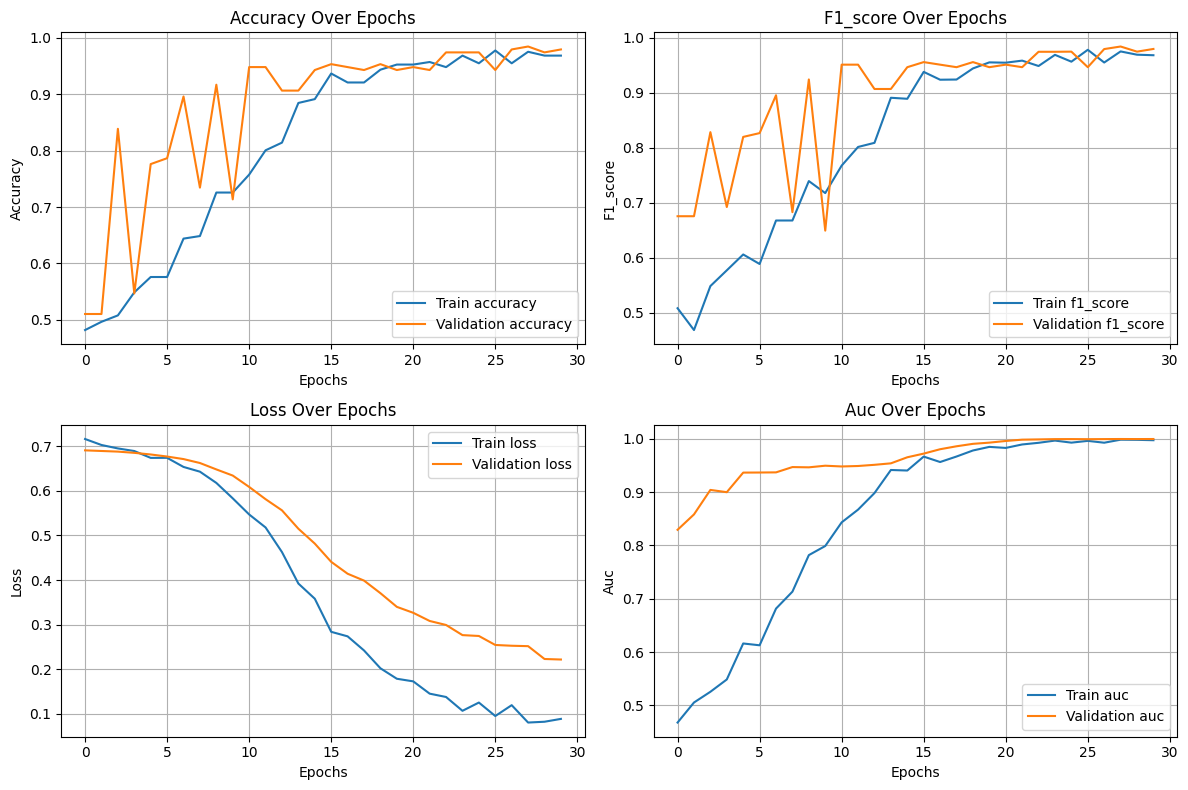

In [12]:
metrics = ["accuracy", "f1_score", "loss",'auc']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1) 
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

### Load model history

In [3]:
import json
import pandas as pd

# Load the JSON file
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Convert the loaded data into a pandas DataFrame
df = pd.DataFrame(history)

# Display the DataFrame
print(df.tail())


    accuracy       auc  f1_score      loss  precision    recall  val_accuracy  \
25  0.977324  0.995850  0.978448  0.094838   0.965957  0.991266      0.942708   
26  0.954649  0.992410  0.955357  0.119204   0.938596  0.972727      0.979167   
27  0.975057  0.998077  0.975501  0.080207   0.960526  0.990950      0.984375   
28  0.968254  0.997808  0.969565  0.082016   0.952991  0.986726      0.973958   
29  0.968254  0.997100  0.968610  0.088418   0.951542  0.986301      0.979167   

     val_auc  val_f1_score  val_loss  val_precision  val_recall  
25  0.999023      0.946860  0.254254       0.899083    1.000000  
26  0.999186      0.979798  0.252527       0.970000    0.989796  
27  0.999349      0.984456  0.251604       1.000000    0.969388  
28  0.999240      0.975124  0.222792       0.951456    1.000000  
29  0.999349      0.980000  0.221613       0.960784    1.000000  


In [6]:
# best_model = tf.keras.models.load_model("best_model.keras", custom_objects={"f1_score": f1_score})
best_val_F1Score = max(df["val_f1_score"])  
best_val_acc = max(df["val_accuracy"])  
best_val_loss = min(df["val_loss"])
best_val_auc = max(df["val_auc"])

print(f"Best Validation F1Score: {best_val_F1Score:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")

Best Validation F1Score: 0.9845
Best Validation Accuracy: 0.9844
Best Validation Loss: 0.2216
Best Validation AUC: 0.9993


### Model Testing

In [ ]:
# test_results = best_model.evaluate(test_dataset)
# print(test_results)